K candidates: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
CV scores:    [0.997, 0.997, 0.997, 0.997, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test scores:  [0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988]
Best k (CV):  11
Best k (Test-only): 1
Test acc at CV-selected k: 0.9875


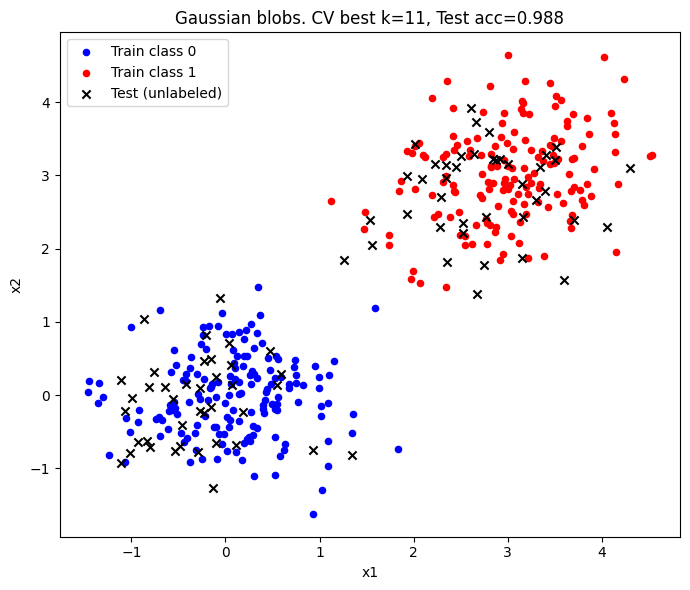

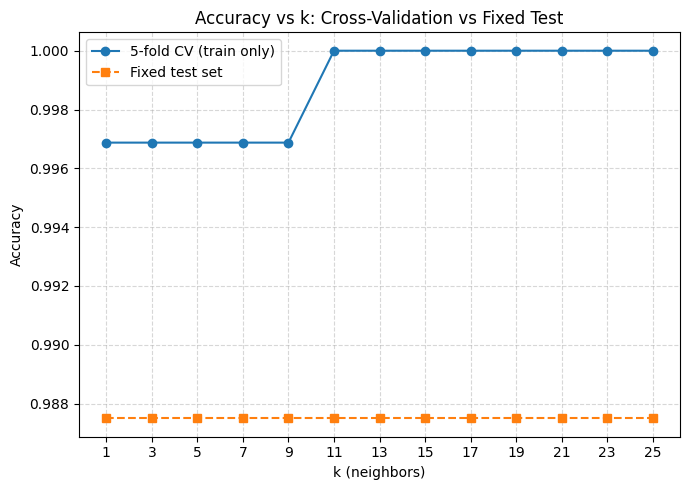

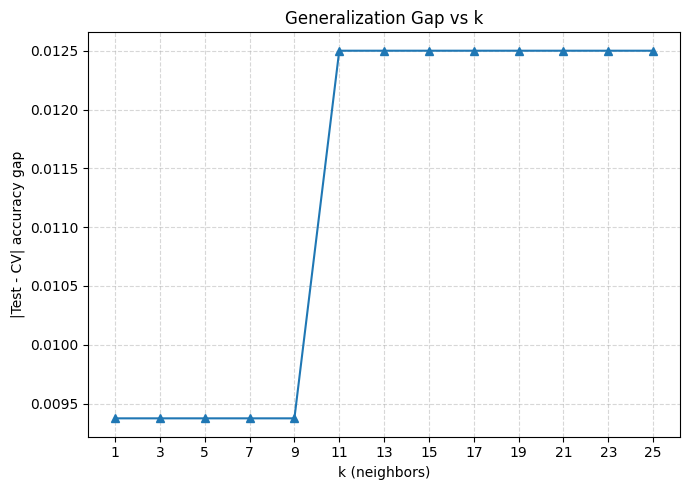

     k  cv_accuracy  test_accuracy   abs_gap  is_best_k_cv  is_best_k_test
0    1     0.996875         0.9875  0.009375             0               1
1    3     0.996875         0.9875  0.009375             0               0
2    5     0.996875         0.9875  0.009375             0               0
3    7     0.996875         0.9875  0.009375             0               0
4    9     0.996875         0.9875  0.009375             0               0
5   11     1.000000         0.9875  0.012500             1               0
6   13     1.000000         0.9875  0.012500             0               0
7   15     1.000000         0.9875  0.012500             0               0
8   17     1.000000         0.9875  0.012500             0               0
9   19     1.000000         0.9875  0.012500             0               0
10  21     1.000000         0.9875  0.012500             0               0
11  23     1.000000         0.9875  0.012500             0               0
12  25     1.000000      

In [ ]:
# knn_numpy_ksearch_demo.py
# NumPy-only KNN with stratified CV to choose k, plus plotting and CV vs Test comparison.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Try optional dataframe display (works in certain notebook envs only)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    _has_display = True
except Exception:
    _has_display = False


def pairwise_distances(A, B):
    A_sq = np.sum(A**2, axis=1, keepdims=True)
    B_sq = np.sum(B**2, axis=1, keepdims=True).T
    cross = A @ B.T
    D_sq = np.maximum(A_sq + B_sq - 2*cross, 0.0)
    return np.sqrt(D_sq)


def knn_predict(X_train, y_train, X_test, k=5):
    D = pairwise_distances(X_test, X_train)
    nn_idx = np.argpartition(D, kth=k-1, axis=1)[:, :k]
    row_idx = np.arange(X_test.shape[0])[:, None]
    nn_sorted = nn_idx[row_idx, np.argsort(D[row_idx, nn_idx], axis=1)]
    nn_labels = y_train[nn_sorted]

    preds = np.empty(X_test.shape[0], dtype=int)
    for i in range(X_test.shape[0]):
        labels, counts = np.unique(nn_labels[i], return_counts=True)
        max_count = counts.max()
        tied = labels[counts == max_count]
        if len(tied) == 1:
            preds[i] = tied[0]
        else:
            # Break tie by choosing class with smaller summed distances
            sums = []
            for cls in tied:
                mask = (nn_labels[i] == cls)
                sums.append(D[i, nn_sorted[i][mask]].sum())
            preds[i] = tied[int(np.argmin(sums))]
    return preds


def stratified_kfold_indices(y, n_splits=5, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    folds = [[] for _ in range(n_splits)]
    for c in classes:
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)
        chunks = np.array_split(idx_c, n_splits)
        for i in range(n_splits):
            folds[i].extend(chunks[i].tolist())
    folds = [np.array(sorted(fold), dtype=int) for fold in folds]
    return folds


def crossval_score_for_k(X, y, k, n_splits=5, seed=0):
    folds = stratified_kfold_indices(y, n_splits=n_splits, seed=seed)
    accs = []
    for i in range(n_splits):
        val_idx = folds[i]
        train_idx = np.setdiff1d(np.arange(len(y)), val_idx)
        X_tr, y_tr = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        y_hat = knn_predict(X_tr, y_tr, X_val, k=k)
        accs.append((y_hat == y_val).mean())
    return float(np.mean(accs))


def choose_best_k(X, y, k_values, n_splits=5, seed=0):
    scores = []
    for k in k_values:
        scores.append(crossval_score_for_k(X, y, k, n_splits=n_splits, seed=seed))
    scores = np.array(scores)
    best_mask = (scores == scores.max())
    best_k = int(np.array(k_values)[best_mask][0])  # prefer smallest k on ties
    return best_k, scores


def accuracy_on_test_for_k(X_train, y_train, X_test, y_test, k_values):
    scores = []
    for k in k_values:
        y_hat = knn_predict(X_train, y_train, X_test, k=k)
        scores.append((y_hat == y_test).mean())
    return np.array(scores, dtype=float)


def generate_dataset(seed=42, n_per_class=200, test_per_class=40):
    rng = np.random.default_rng(seed)
    mean0, mean1 = np.array([0.0, 0.0]), np.array([3.0, 3.0])
    cov = np.array([[0.4, 0.0], [0.0, 0.4]])
    X0 = rng.multivariate_normal(mean0, cov, size=n_per_class)
    X1 = rng.multivariate_normal(mean1, cov, size=n_per_class)
    y0 = np.zeros(n_per_class, dtype=int)
    y1 = np.ones(n_per_class, dtype=int)
    X = np.vstack([X0, X1])
    y = np.hstack([y0, y1])

    # stratified split
    idx0 = rng.permutation(n_per_class)
    idx1 = rng.permutation(n_per_class)
    test_idx0 = idx0[:test_per_class]
    train_idx0 = idx0[test_per_class:]
    test_idx1 = idx1[:test_per_class] + n_per_class
    train_idx1 = idx1[test_per_class:] + n_per_class
    train_idx = np.hstack([train_idx0, train_idx1])
    test_idx = np.hstack([test_idx0, test_idx1])
    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


def main(seed=42, n_per_class=200, test_per_class=40, k_values=None):
    if k_values is None:
        k_values = list(range(1, 26, 2))

    X_train, y_train, X_test, y_test = generate_dataset(seed, n_per_class, test_per_class)

    # Choose k via CV
    best_k, cv_scores = choose_best_k(X_train, y_train, k_values, n_splits=5, seed=123)
    # Evaluate on test set
    test_scores = accuracy_on_test_for_k(X_train, y_train, X_test, y_test, k_values)
    best_k_test = int(np.array(k_values)[np.argmax(test_scores)])

    # Final test accuracy at CV-selected k
    y_pred = knn_predict(X_train, y_train, X_test, k=best_k)
    test_acc = (y_pred == y_test).mean()

    # Summary
    print("K candidates:", k_values)
    print("CV scores:   ", np.round(cv_scores, 3).tolist())
    print("Test scores: ", np.round(test_scores, 3).tolist())
    print("Best k (CV): ", best_k)
    print("Best k (Test-only):", best_k_test)
    print("Test acc at CV-selected k:", round(float(test_acc), 4))

    # --- Plot 1: Scatter of points ---
    plt.figure(figsize=(7, 6))
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], s=20, label="Train class 0", c='blue')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], s=20, label="Train class 1", c='red')
    plt.scatter(X_test[:, 0], X_test[:, 1], s=35, label="Test (unlabeled)", c='black', marker='x')
    plt.title(f"Gaussian blobs. CV best k={best_k}, Test acc={test_acc:.3f}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.tight_layout()
    plt.show()

    # --- Plot 2: Accuracy vs k ---
    plt.figure(figsize=(7, 5))
    plt.plot(k_values, cv_scores, marker='o', label="5-fold CV (train only)")
    plt.plot(k_values, test_scores, marker='s', linestyle='--', label="Fixed test set")
    plt.xticks(k_values)
    plt.xlabel("k (neighbors)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs k: Cross-Validation vs Fixed Test")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(); plt.tight_layout(); plt.show()

    # --- Plot 3: Generalization gap ---
    gap = np.abs(test_scores - cv_scores)
    plt.figure(figsize=(7, 5))
    plt.plot(k_values, gap, marker='^')
    plt.xticks(k_values)
    plt.xlabel("k (neighbors)")
    plt.ylabel("|Test - CV| accuracy gap")
    plt.title("Generalization Gap vs k")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

    # --- Table ---
    df = pd.DataFrame({
        "k": k_values,
        "cv_accuracy": cv_scores,
        "test_accuracy": test_scores,
        "abs_gap": gap,
        "is_best_k_cv": [int(k == best_k) for k in k_values],
        "is_best_k_test": [int(k == best_k_test) for k in k_values],
    })
    if _has_display:
        display_dataframe_to_user("KNN CV vs Test Comparison", df)
    else:
        print(df)

    return best_k, cv_scores, test_scores


if __name__ == "__main__":
    main()
